<a href="https://colab.research.google.com/github/KelseyWang2022/accident_data_analysis/blob/main/rf%2BALE(imbalanced%20data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alibi
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully uninstalled attrs-24.2.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


Accuracy: 0.8246001103143961
Classification Report:
              precision    recall  f1-score   support

       death       1.00      0.40      0.57         5
minor injury       0.78      0.85      0.81      1381
   no injury       0.86      0.86      0.86      1823
      severe       0.84      0.61      0.70       417

    accuracy                           0.82      3626
   macro avg       0.87      0.68      0.74      3626
weighted avg       0.83      0.82      0.82      3626



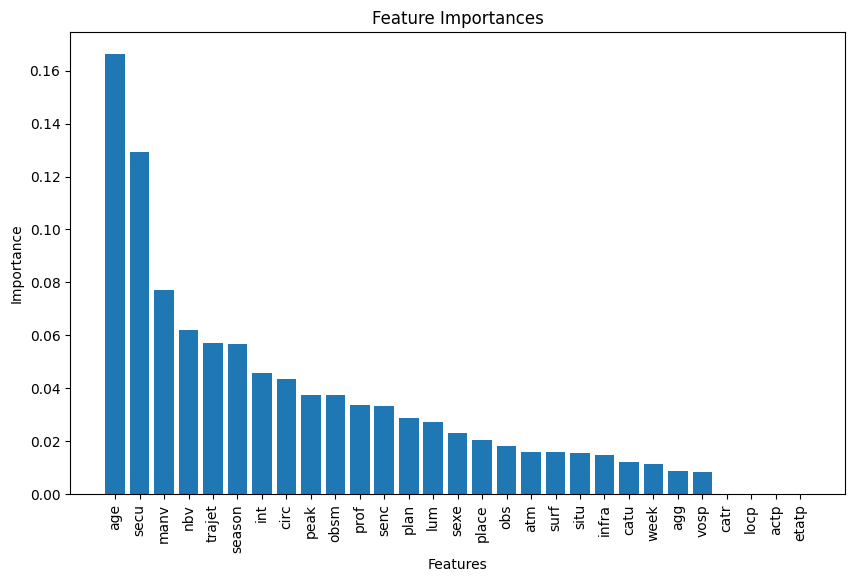

In [ ]:
# 导入必要的库
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce  # 用于目标编码

# 加载数据集
df = pd.read_csv(r'/content/merged_accidents_2014_2018_catr4.csv', low_memory=False)

# 定义分类和数值特征
categorical_features = ['lum', 'agg', 'int', 'atm', 'season', 'week', 'peak', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf',
                        'infra', 'situ', 'senc', 'obs', 'obsm', 'manv', 'place', 'catu', 'sexe', 'trajet', 'secu', 'locp',
                        'actp', 'etatp', 'nbv']
numeric_features = ['age']
target = 'grav'

# 处理分类特征的缺失值并转换为分类数据类型
df[categorical_features] = df[categorical_features].replace('Missing', pd.NA)
df = df.dropna(subset=categorical_features + numeric_features + [target])

# 将分类特征转换为类别类型
df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))

# 处理类别不平衡，假设"no injury"为多数类别
df_majority = df[df[target] == 'no injury']
df_minority = df[df[target] != 'no injury']

# 上采样少数类
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# 拆分特征和目标
X = df_balanced[categorical_features + numeric_features]
y = df_balanced[target]

# 使用LabelEncoder对目标变量进行编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 使用目标编码来处理分类变量
target_encoder = ce.TargetEncoder(cols=categorical_features)

# 对训练集进行目标编码
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

# 数值特征标准化
scaler = StandardScaler()
X_train_encoded[numeric_features] = scaler.fit_transform(X_train_encoded[numeric_features])
X_test_encoded[numeric_features] = scaler.transform(X_test_encoded[numeric_features])

# 构建并训练随机森林模型
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# 进行预测
y_pred = rf_model.predict(X_test_encoded)

# 将数值型预测结果转换回原始标签
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# 评估模型性能
accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

# 输出结果
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# 1. 可视化特征重要性
importances = rf_model.feature_importances_

# 获取特征名称
feature_names = list(X_train_encoded.columns)

# 可视化特征重要性,按照降序的顺序
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation='vertical')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()




In [ ]:
# 首先确保安装shap库
!pip install shap

In [ ]:
print(f"shap_values[class_idx] shape: {shap_values[class_idx].shape}, X_test_original shape: {X_test_original.shape}")


shap_values[class_idx] shape: (29, 4), X_test_original shape: (3626, 29)


In [ ]:
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

# 假设你已经有训练好的模型 rf_model 和编码后的测试数据 X_test_encoded

# 生成 SHAP 值（对于多分类问题）
explainer = shap.TreeExplainer(rf_model)  # 对于树模型可以使用 TreeExplainer
shap_values = explainer.shap_values(X_test_encoded)

# 打印 SHAP 值的形状以检查
print(f"SHAP values shape: {[sv.shape for sv in shap_values]}")

# 对每个类别进行 SHAP 分析
n_classes = len(shap_values)  # 多分类的类别数

for class_idx in range(n_classes):
    print(f"Class {class_idx} SHAP analysis")

    # 检查当前类别的 SHAP 值形状是否匹配特征矩阵
    if shap_values[class_idx].shape[0] != X_test_encoded.shape[0]:
        raise ValueError(f"Mismatch in rows between SHAP values and test data for class {class_idx}. "
                         f"Expected {X_test_encoded.shape[0]}, but got {shap_values[class_idx].shape[0]}.")

    # 对当前类别的样本可视化 SHAP 值
    shap.summary_plot(shap_values[class_idx], X_test_encoded, plot_type="bar", show=False)
    plt.title(f"SHAP Summary Plot for Class {class_idx}")
    plt.show()


SHAP values shape: [(29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4), (29, 4),

ValueError: Mismatch in rows between SHAP values and test data for class 0. Expected 3626, but got 29.

In [ ]:
# 导入必要的库
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # 用于绘制热力图
import category_encoders as ce  # 用于目标编码
from itertools import combinations
from collections import defaultdict

# 加载数据集
df = pd.read_csv(r'/content/merged_accidents_2014_2018_catr4.csv', low_memory=False)

# 定义分类和数值特征
categorical_features = ['lum', 'agg', 'int', 'atm', 'season', 'week', 'peak', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf',
                        'infra', 'situ', 'senc', 'catv', 'obs', 'obsm', 'manv', 'place', 'catu', 'sexe', 'trajet', 'secu', 'locp',
                        'actp', 'etatp', 'nbv']
numeric_features = ['age']
target = 'grav'

# 处理分类特征的缺失值并转换为分类数据类型
df[categorical_features] = df[categorical_features].replace('Missing', pd.NA)
df = df.dropna(subset=categorical_features + numeric_features + [target])

# 将分类特征转换为类别类型
df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))

# 处理类别不平衡，假设"no injury"为多数类别
df_majority = df[df[target] == 'no injury']
df_minority = df[df[target] != 'no injury']

# 上采样少数类
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# 拆分特征和目标
X = df_balanced[categorical_features + numeric_features]
y = df_balanced[target]

# 使用LabelEncoder对目标变量进行编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 使用目标编码来处理分类变量
target_encoder = ce.TargetEncoder(cols=categorical_features)

# 对训练集进行目标编码
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

# 数值特征标准化
scaler = StandardScaler()
X_train_encoded[numeric_features] = scaler.fit_transform(X_train_encoded[numeric_features])
X_test_encoded[numeric_features] = scaler.transform(X_test_encoded[numeric_features])

# 构建并训练随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# 评估模型性能
y_pred = rf_model.predict(X_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"模型准确率: {accuracy:.2f}")
print("分类报告:")
print(classification_report(y_test_labels, y_pred_labels))

# ===================== 统计交互特征的频率 ===================== #
def extract_feature_interactions(tree, feature_names):
    # 获取每棵树的结构
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    features = tree.tree_.feature

    # 遍历每棵树的每条路径，统计同一路径上的特征组合
    feature_pairs = []
    def recurse(node, path):
        if children_left[node] == children_right[node]:  # 叶子节点
            for i in range(len(path)):
                for j in range(i + 1, len(path)):
                    feature_pairs.append((path[i], path[j]))  # 保存同一路径上的特征组合
        else:
            if children_left[node] != -1:
                recurse(children_left[node], path + [features[node]])
            if children_right[node] != -1:
                recurse(children_right[node], path + [features[node]])

    recurse(0, [])
    return feature_pairs




模型准确率: 0.85
分类报告:
              precision    recall  f1-score   support

       death       1.00      0.60      0.75         5
minor injury       0.82      0.83      0.83      1381
   no injury       0.86      0.91      0.88      1823
      severe       0.90      0.64      0.74       417

    accuracy                           0.85      3626
   macro avg       0.89      0.74      0.80      3626
weighted avg       0.85      0.85      0.84      3626



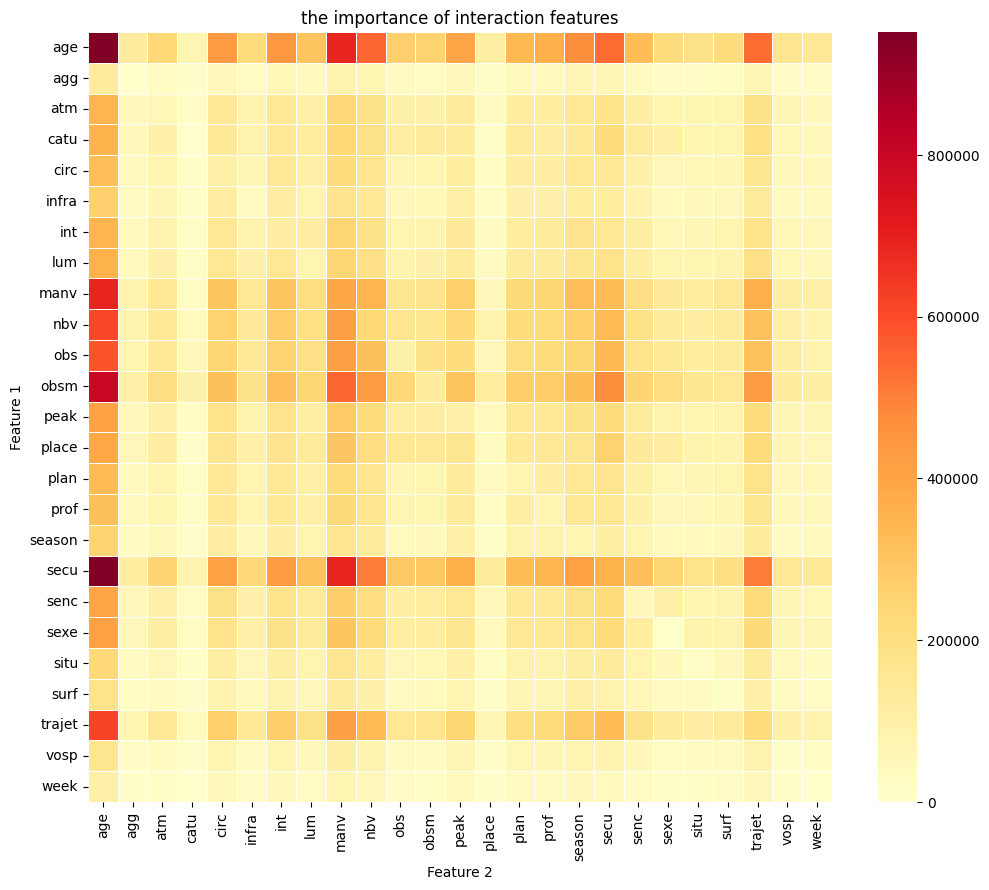

In [ ]:
# ===================== 可视化特征交互的重要性热力图 ===================== #
# 统计所有树中出现的特征交互频率
interaction_counter = defaultdict(int)
for tree in rf_model.estimators_:
    feature_pairs = extract_feature_interactions(tree, X_train_encoded.columns)
    for pair in feature_pairs:
        interaction_counter[pair] += 1

# 获取特征名称并转换为易读的形式
interaction_freqs = [(X_train_encoded.columns[pair[0]], X_train_encoded.columns[pair[1]], count)
                     for pair, count in interaction_counter.items()]

# 将交互特征的数据转换为DataFrame
interaction_df = pd.DataFrame(interaction_freqs, columns=['Feature 1', 'Feature 2', 'Frequency'])

# 使用 pivot_table 来创建特征交互的重要性矩阵
interaction_pivot = interaction_df.pivot_table(index='Feature 1', columns='Feature 2', values='Frequency', fill_value=0)

# 绘制热力图
plt.figure(figsize=(12, 10))
sns.heatmap(interaction_pivot, annot=False, cmap="YlOrRd", linewidths=0.5)
plt.title('the importance of interaction features')
plt.show()


In [ ]:
#输出上述结果中前10个最重要的交互特征组合
sorted_interactions = sorted(interaction_counter.items(), key=lambda x: x[1], reverse=True)
top_10_interactions = sorted_interactions[:10]
for pair, count in top_10_interactions:
    print(f"Feature 1: {X_train_encoded.columns[pair[0]]}, Feature 2: {X_train_encoded.columns[pair[1]]}, Frequency: {count}")


Feature 1: age, Feature 2: age, Frequency: 951771
Feature 1: secu, Feature 2: age, Frequency: 950273
Feature 1: obsm, Feature 2: age, Frequency: 797013
Feature 1: manv, Feature 2: age, Frequency: 691080
Feature 1: age, Feature 2: manv, Frequency: 691040
Feature 1: secu, Feature 2: manv, Frequency: 690677
Feature 1: trajet, Feature 2: age, Frequency: 618363
Feature 1: nbv, Feature 2: age, Frequency: 610113
Feature 1: obs, Feature 2: age, Frequency: 585161
Feature 1: obsm, Feature 2: manv, Frequency: 546886


In [ ]:
!pip install alibi
!pip install category_encoders
!pip install pdpbox
!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a2fb01

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X

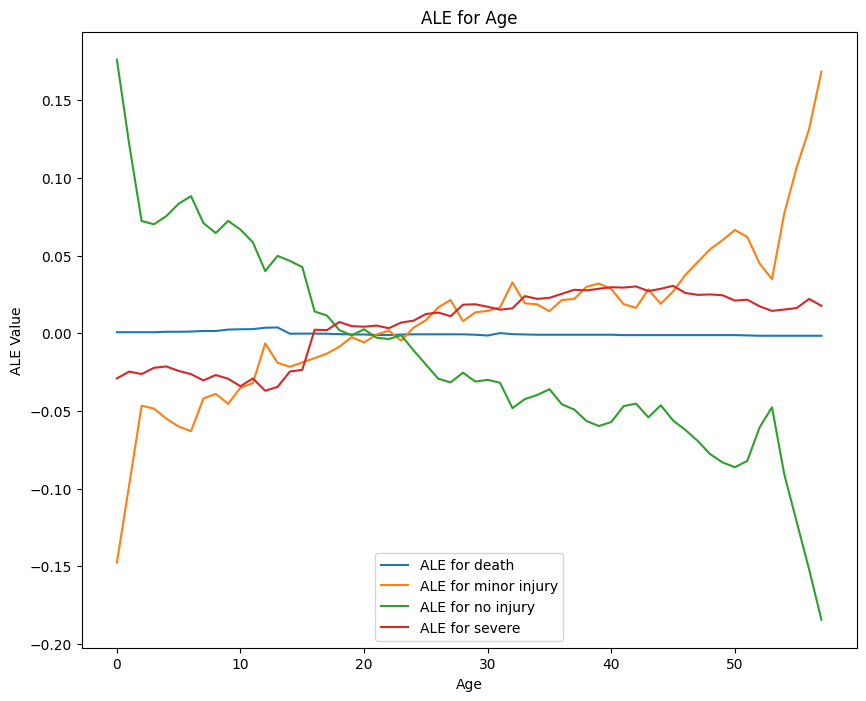

In [ ]:
#age的可视化结果
import alibi
from alibi.explainers import ALE
# 定义可调用的预测函数
def predict_fn(X):
    return rf_model.predict_proba(X)

# 使用 ALE 可解释器
ale_explainer = ALE(predict_fn, feature_names=X_train_encoded.columns.tolist())

# 使用训练集的 X 数据来进行解释
ale_exp = ale_explainer.explain(X_test_encoded.values)

# ===================== 可视化 age 特征的 ALE 图 ===================== #
# 提取 age 特征的 ALE 结果
age_feature_idx = X_train_encoded.columns.tolist().index('age')

# 获取类别名称
class_labels = label_encoder.classes_

# 绘制 age 特征的 ALE 结果
fig, ax = plt.subplots(figsize=(10, 8))
for i, label in enumerate(class_labels):
    ax.plot(ale_exp.ale_values[age_feature_idx][:, i], label=f'ALE for {label}')

ax.set_xlabel('Age')
ax.set_ylabel('ALE Value')
ax.set_title('ALE for Age')
plt.legend()
plt.show()



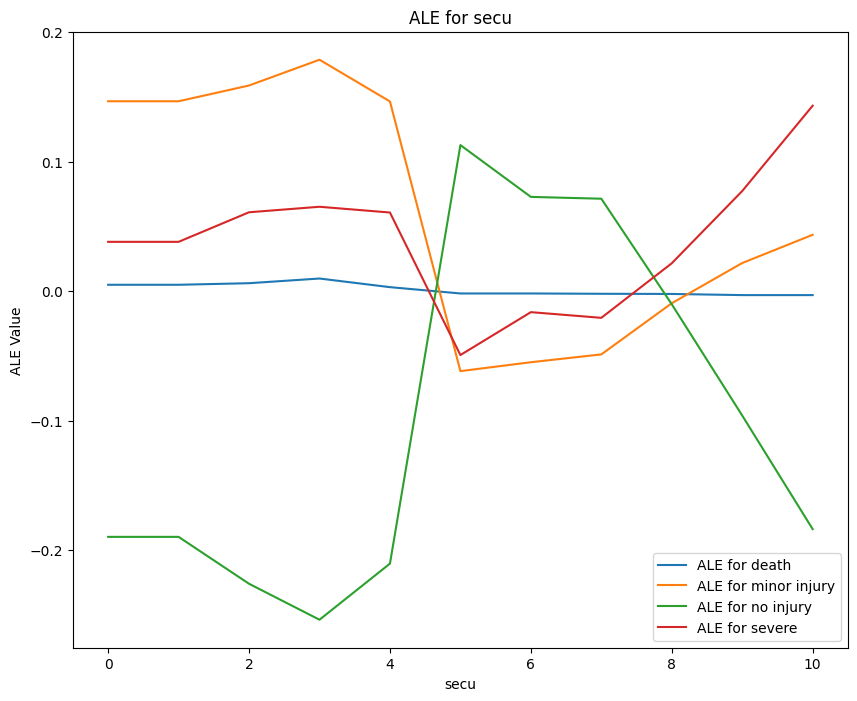

In [ ]:
#secu的可视化结果
import alibi
from alibi.explainers import ALE
# 定义可调用的预测函数
def predict_fn(X):
    return rf_model.predict_proba(X)

# 使用 ALE 可解释器
ale_explainer = ALE(predict_fn, feature_names=X_train_encoded.columns.tolist())

# 使用训练集的 X 数据来进行解释
ale_exp = ale_explainer.explain(X_test_encoded.values)

# ===================== 可视化 age 特征的 ALE 图 ===================== #
# 提取 age 特征的 ALE 结果
age_feature_idx = X_train_encoded.columns.tolist().index('secu')

# 获取类别名称
class_labels = label_encoder.classes_

# 绘制 age 特征的 ALE 结果
fig, ax = plt.subplots(figsize=(10, 8))
for i, label in enumerate(class_labels):
    ax.plot(ale_exp.ale_values[age_feature_idx][:, i], label=f'ALE for {label}')

ax.set_xlabel('secu')
ax.set_ylabel('ALE Value')
ax.set_title('ALE for secu')
plt.legend()
plt.show()



RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

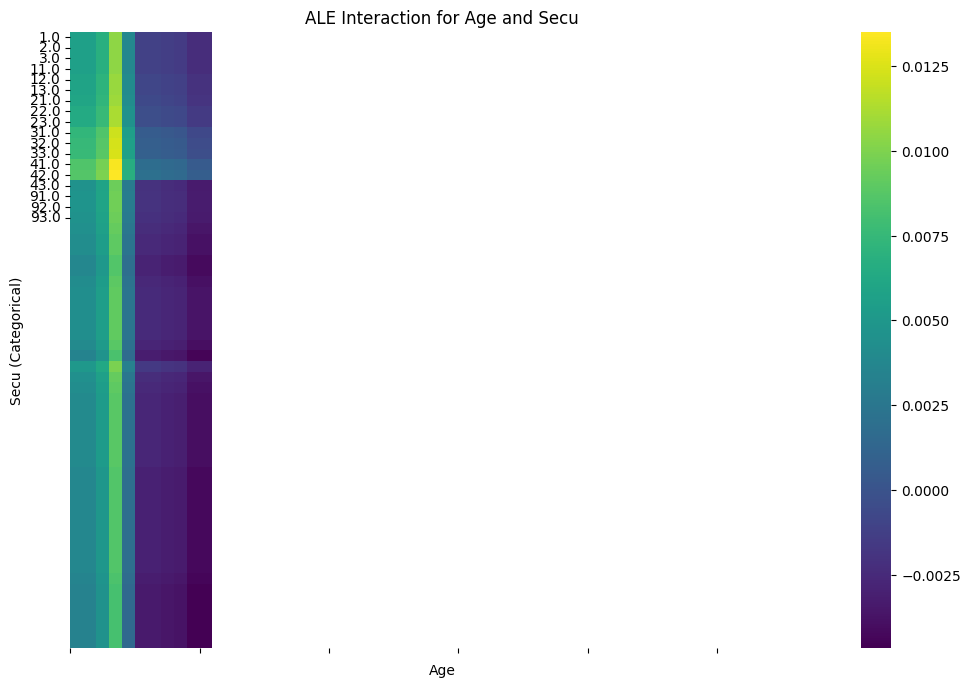

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 提取 age 和 secu 特征的 ALE 值
age_ale_values = ale_exp.ale_values[age_feature_idx]  # 获取 age 的 ALE 值
secu_ale_values = ale_exp.ale_values[secu_feature_idx]  # 获取 secu 的 ALE 值

# 获取原始的 age 和 secu 特征的值
age_values = ale_exp.feature_values[age_feature_idx]  # age 是连续变量
secu_values = ale_exp.feature_values[secu_feature_idx]  # secu 是分类变量

# 确保 secu_values 是类别标签，而不是数值
# 替换 secu_values 为分类特征的原始标签
secu_labels = X_train['secu'].cat.categories.tolist()

# 创建 2D 网格和相应的 ALE 值矩阵
# 我们假设简单叠加 age 和 secu 的 ALE 值
ale_interaction = np.add.outer(age_ale_values[:, 0], secu_ale_values[:, 0])

# 使用 seaborn 绘制热力图，展示 age 和 secu 的交互效应
plt.figure(figsize=(12, 8))

# 绘制热力图
sns.heatmap(ale_interaction,
            xticklabels=age_values,
            yticklabels=secu_labels,  # 使用 secu 的分类标签
            cmap="viridis")

# 调整标签的间隔并旋转标签，避免重叠
plt.xticks(np.arange(0, len(age_values), step=10), rotation=45)  # 每隔10个显示一个 age 标签
plt.yticks(rotation=0)  # 保持 secu 标签水平显示

plt.xlabel('Age')
plt.ylabel('Secu (Categorical)')
plt.title('ALE Interaction for Age and Secu')
plt.colorbar()
plt.show()


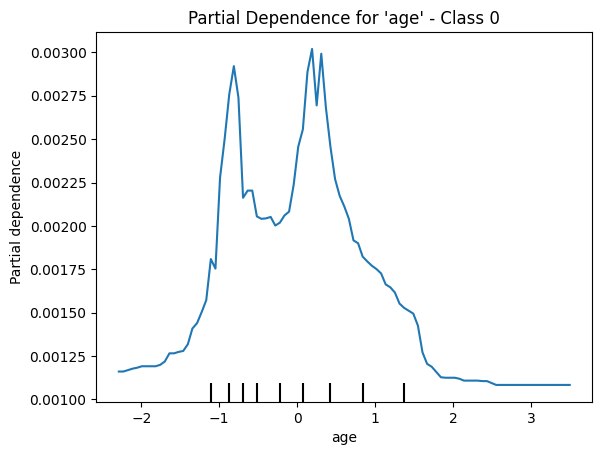

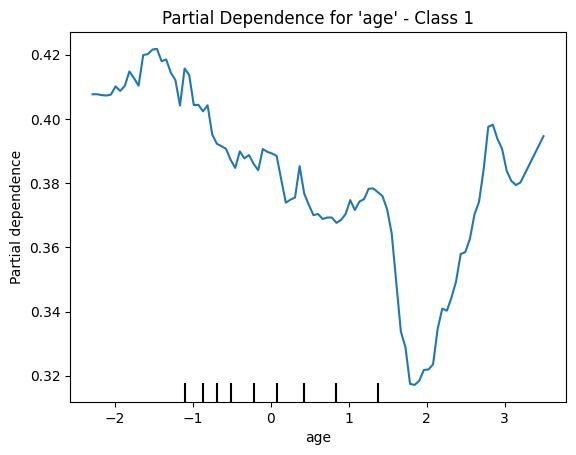

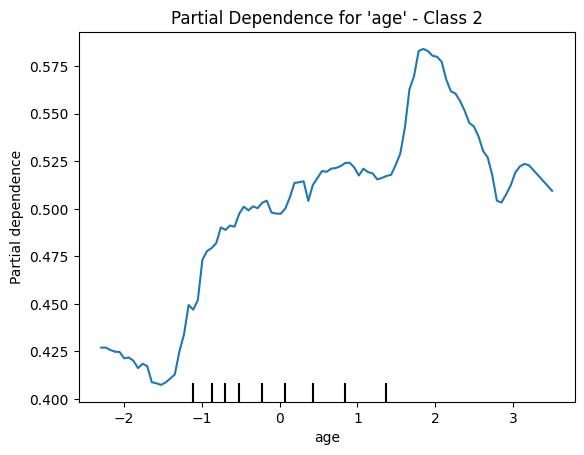

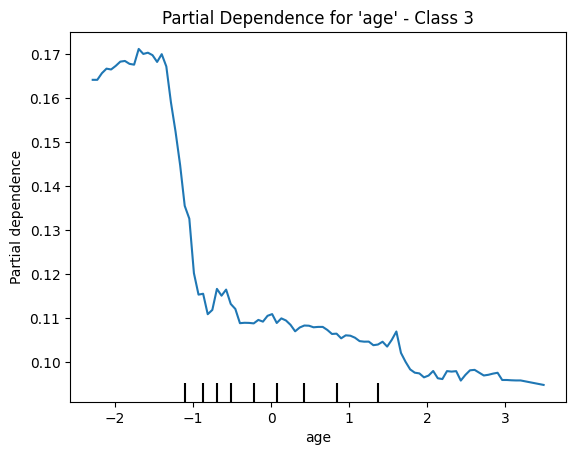

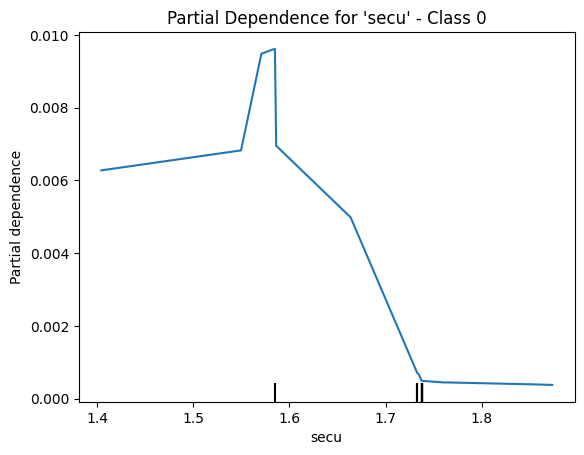

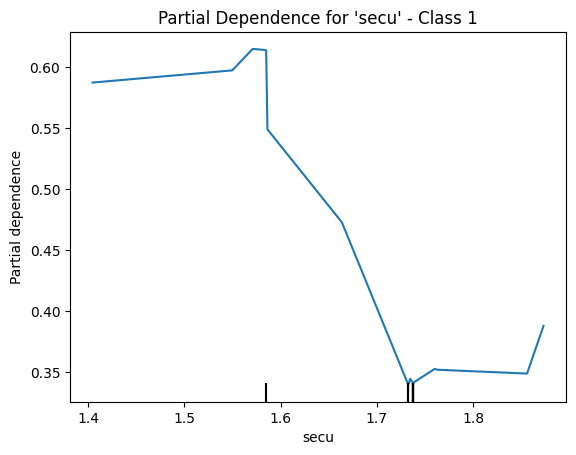

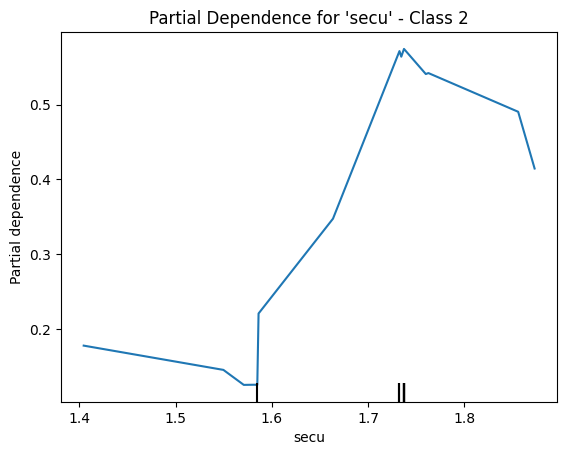

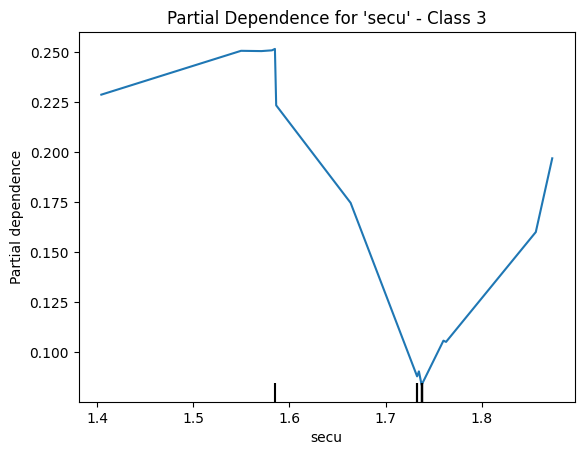

In [ ]:
# 绘制 'age' 特征的部分依赖图，针对所有类别
for i, class_label in enumerate(rf_model.classes_):
    PartialDependenceDisplay.from_estimator(rf_model, X_test_encoded, ['age'], target=i)
    plt.title(f"Partial Dependence for 'age' - Class {class_label}")
    plt.show()

# 绘制 'secu' 特征的部分依赖图，针对所有类别
for i, class_label in enumerate(rf_model.classes_):
    PartialDependenceDisplay.from_estimator(rf_model, X_test_encoded, ['secu'], target=i)
    plt.title(f"Partial Dependence for 'secu' - Class {class_label}")
    plt.show()


In [ ]:
!pip install lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# 创建 LIME 解释器
explainer = LimeTabularExplainer(X_train_encoded.values, feature_names=X_train_encoded.columns.tolist(), class_names=label_encoder.classes_, mode='classification')

# 使用 LIME 分别生成每个类别的解释
for class_idx in range(len(label_encoder.classes_)):  # 对四个类别分别解释
    exp = explainer.explain_instance(X_test_encoded.iloc[i].values, rf_model.predict_proba, labels=[class_idx])
    exp.show_in_notebook(show_table=True, show_all=True)


NameError: name 'output_dir' is not defined

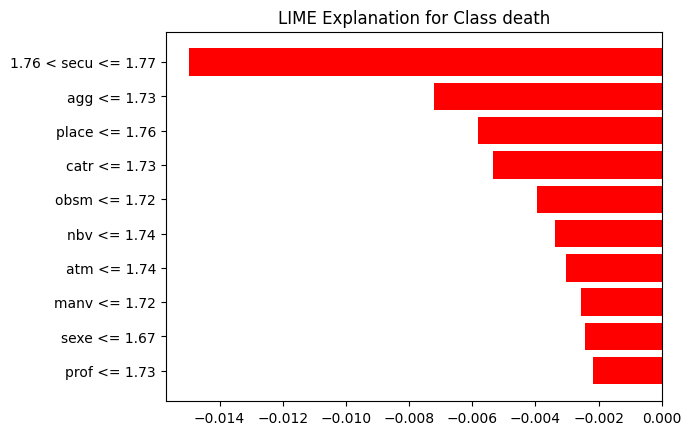

In [ ]:
import matplotlib.pyplot as plt
import os

# 生成并绘制解释结果
for class_idx in range(len(label_encoder.classes_)):
    try:
        exp = explainer.explain_instance(
            X_test_encoded.iloc[i].values,
            rf_model.predict_proba,
            labels=[class_idx]
        )

        # 绘制图像
        fig = exp.as_pyplot_figure(label=class_idx)
        plt.title(f'LIME Explanation for Class {label_encoder.classes_[class_idx]}')

        # 保存图像
        output_file = os.path.join(output_dir, f'lime_explanation_class_{class_idx}.png')
        fig.savefig(output_file)
        plt.close(fig)
    except KeyError as e:
        print(f"Error for class {class_idx}: {e}")
